In [16]:
#导入必要依赖库
import torch.optim
import  torchvision
from torch.nn import Linear, Flatten, MaxPool2d, Conv2d
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import  nn
from torch.utils.tensorboard import SummaryWriter
import os
import pandas as pd
from PIL import Image
import torch.nn.init as init
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



In [17]:


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=7):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [18]:
# 文件夹准备
# 拼接模型保存路径
folder_path = "../models/res_parm"

Train_data_path = '../RAF/images/train'
test_data_path = "../RAF/images/test"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)  


In [19]:

###准备数据集和测试集
###Tensor 形状： torch.Size([3, 100, 100]) 图像模式： RGB
transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize((48,48)),          #统一尺寸
    torchvision.transforms.ToTensor(),                   # 转换为 [C, H, W] 的张量，范围 [0, 1]
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])  
])
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),       # 水平翻转
    torchvision.transforms.RandomRotation(10),                # 旋转 ±10°
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 颜色抖动
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [20]:
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
loss_function=loss_function.cuda()

torch.cuda.empty_cache()## 训练之前清理显存避免显存爆炸

lr_values = [1e-3, 1e-4, 1e-5]
batch_size_values = [32,64, 128]
weight_decay_values= [ 1e-4, 1e-5,1e-6]
best_acc_values_in_each=[]
Res_values = [ [2, 2, 2, 2], [3, 4, 6, 3]]
results = []

开始训练：lr=0.001, res=[2, 2, 2, 2],weight_decay=0.0001,batch_size=32, epochs=30
---------第1轮训练开始---------
训练次数100，Loss：1.6440626382827759
训练次数200，Loss：1.8298369646072388
训练次数300，Loss：1.6178181171417236
正确率0.36277705345501954
整体测试集上的Loss167.84011888504028
---------第2轮训练开始---------
训练次数400，Loss：1.6991760730743408
训练次数500，Loss：1.4987629652023315
训练次数600，Loss：1.4682097434997559
训练次数700，Loss：1.2046830654144287
正确率0.6261408083441982
整体测试集上的Loss117.33992683887482
---------第3轮训练开始---------
训练次数800，Loss：1.2077422142028809
训练次数900，Loss：1.0250390768051147
训练次数1000，Loss：1.509435772895813
训练次数1100，Loss：1.1115942001342773
正确率0.6851368970013038
整体测试集上的Loss106.21571737527847
---------第4轮训练开始---------
训练次数1200，Loss：1.3359646797180176
训练次数1300，Loss：1.3064769506454468
训练次数1400，Loss：1.0307393074035645
训练次数1500，Loss：1.088639497756958
正确率0.7161016949152542
整体测试集上的Loss98.89969944953918
---------第5轮训练开始---------
训练次数1600，Loss：1.1549873352050781
训练次数1700，Loss：1.1675233840942383
训练次数1800，Loss：0.9679673910140991
训练

d:\Users\ROG\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


训练次数100，Loss：1.7448863983154297
训练次数200，Loss：1.6908752918243408
训练次数300，Loss：1.5642541646957397
正确率0.43578878748370276
整体测试集上的Loss147.18779212236404
---------第2轮训练开始---------
训练次数400，Loss：1.3641278743743896
训练次数500，Loss：1.5046532154083252
训练次数600，Loss：1.5335849523544312
训练次数700，Loss：1.300355076789856
正确率0.5426988265971316
整体测试集上的Loss130.0413380265236
---------第3轮训练开始---------
训练次数800，Loss：1.4384589195251465
训练次数900，Loss：1.3956571817398071
训练次数1000，Loss：1.0747053623199463
训练次数1100，Loss：1.3471908569335938
正确率0.5990873533246415
整体测试集上的Loss121.23063379526138
---------第4轮训练开始---------
训练次数1200，Loss：1.3467700481414795
训练次数1300，Loss：1.3823329210281372
训练次数1400，Loss：1.2533228397369385
训练次数1500，Loss：1.1487094163894653
正确率0.6290743155149935
整体测试集上的Loss114.9559211730957
---------第5轮训练开始---------
训练次数1600，Loss：1.0754709243774414
训练次数1700，Loss：1.1142404079437256
训练次数1800，Loss：1.3612490892410278
训练次数1900，Loss：1.0655063390731812
正确率0.6483050847457628
整体测试集上的Loss111.47699505090714
---------第6轮训练开始----

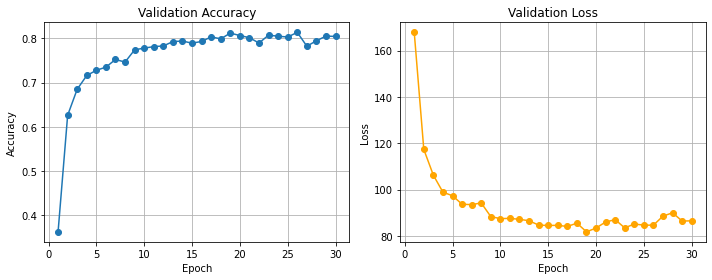

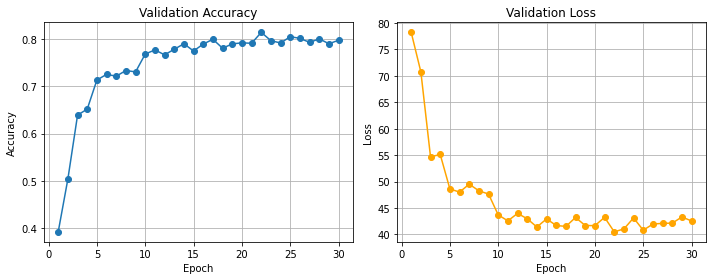

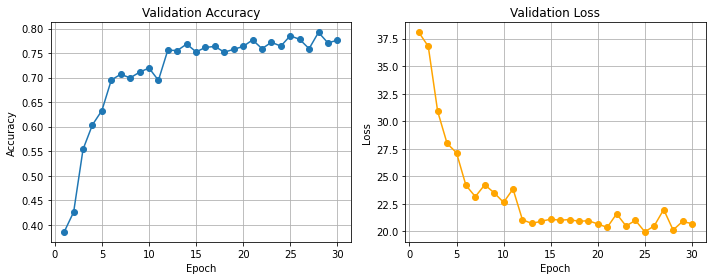

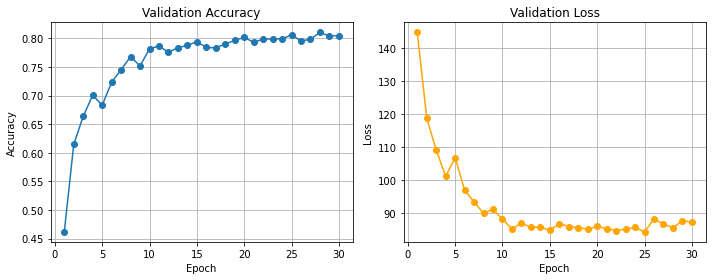

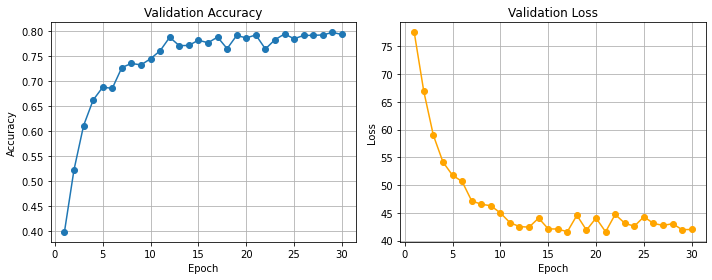

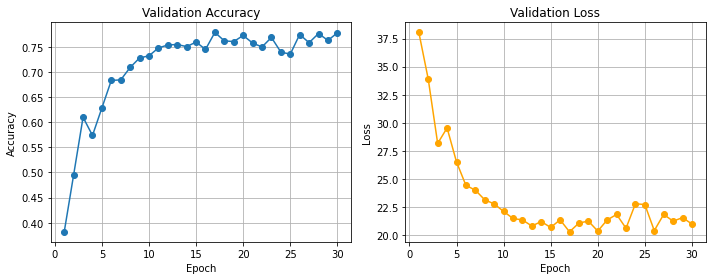

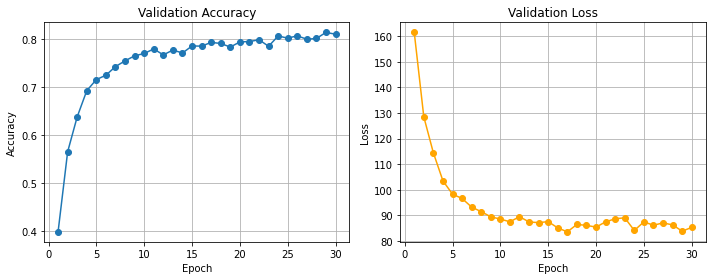

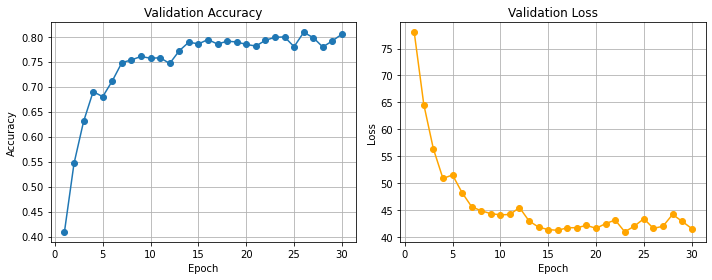

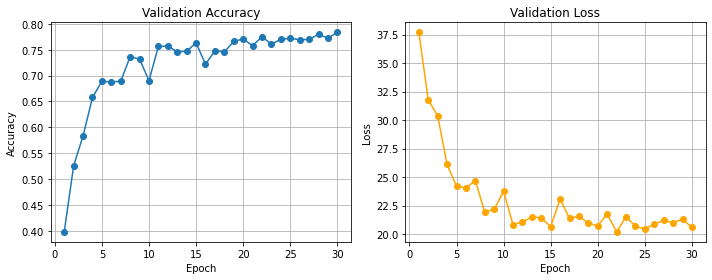

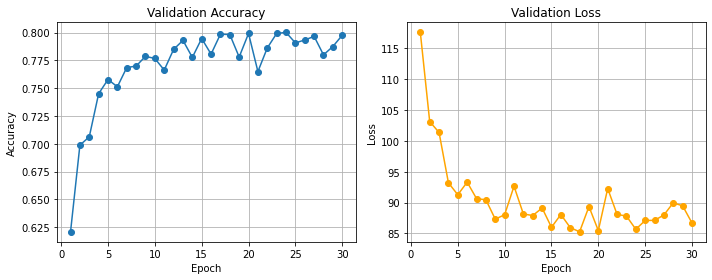

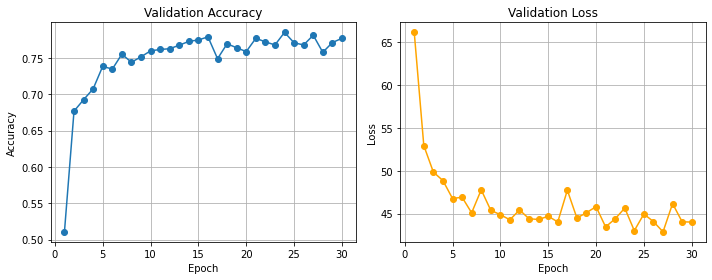

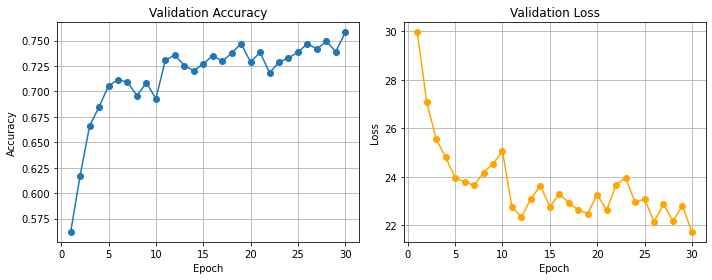

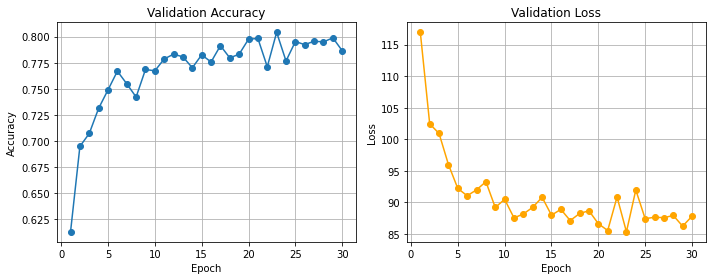

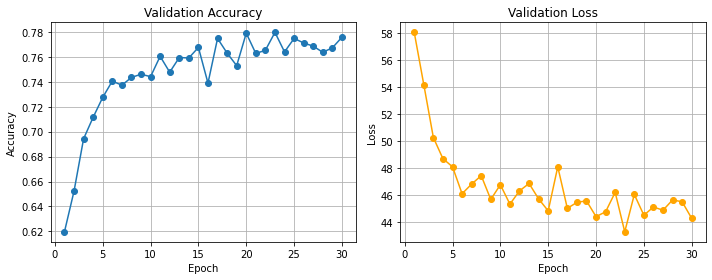

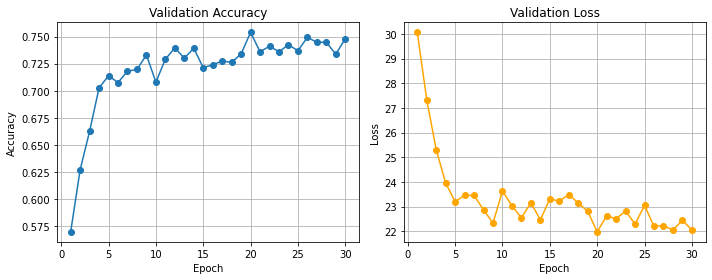

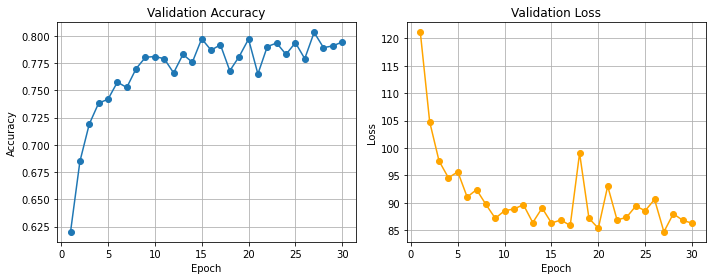

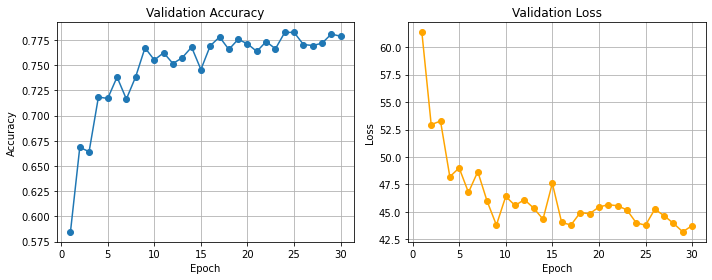

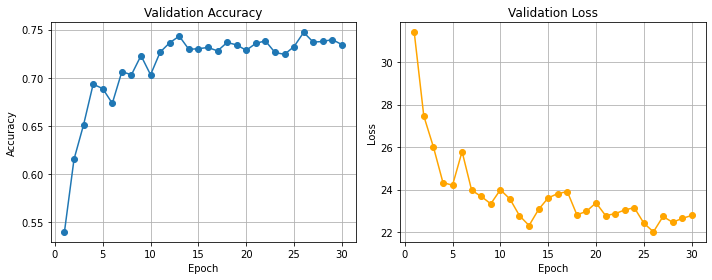

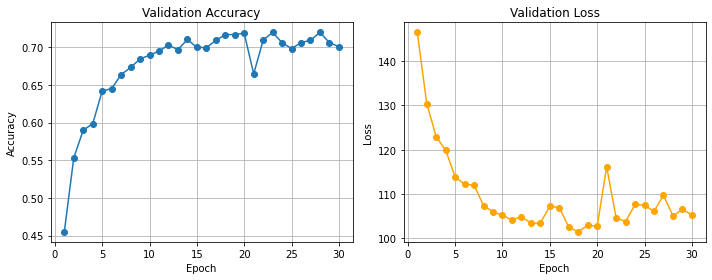

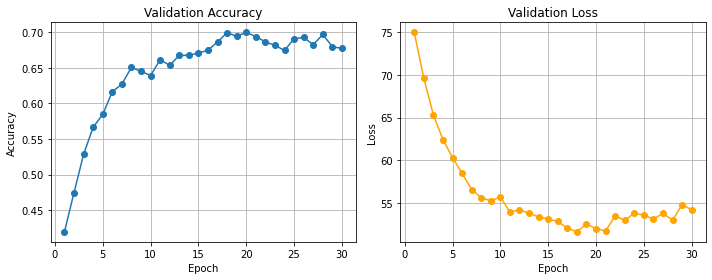

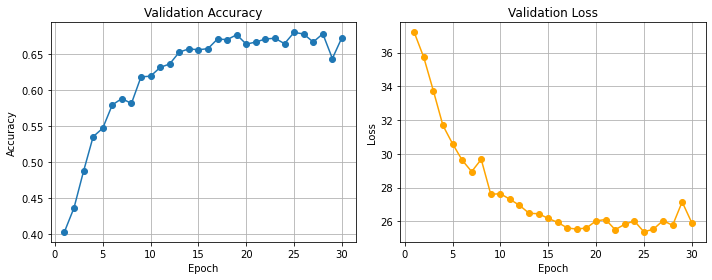

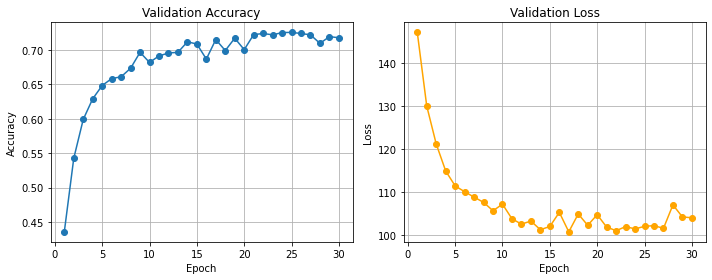

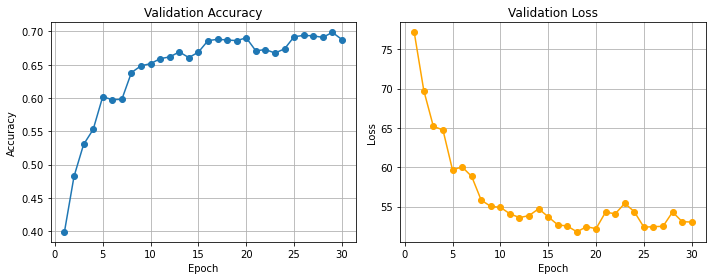

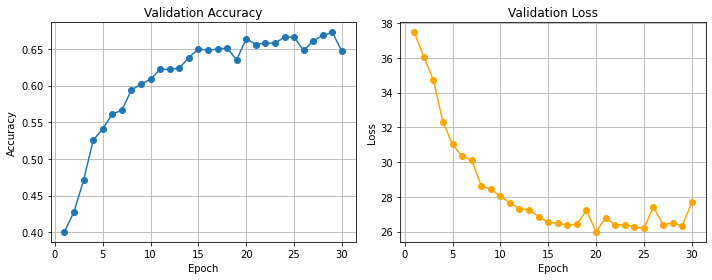

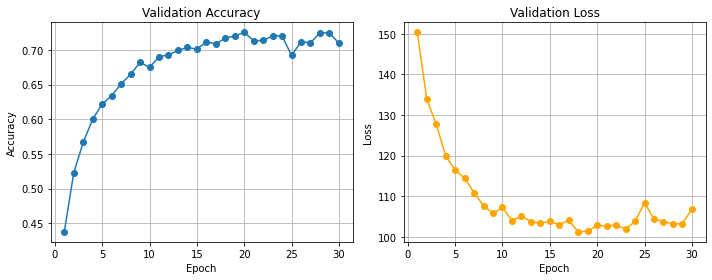

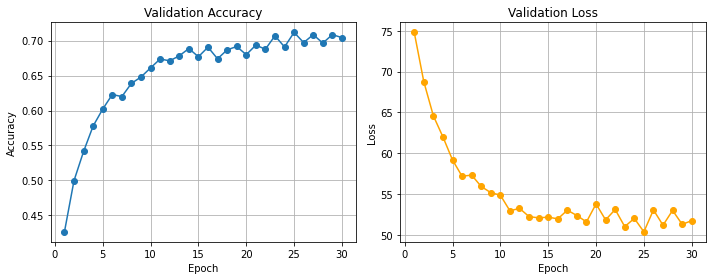

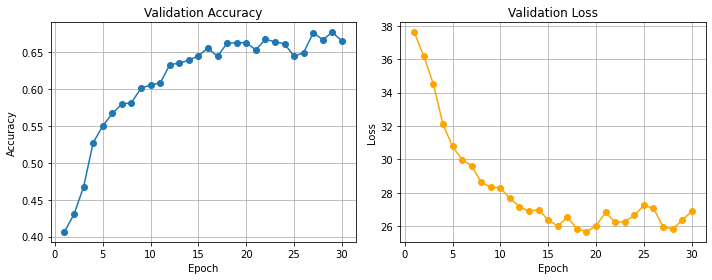

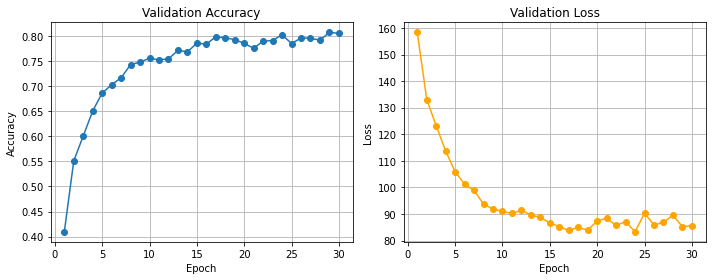

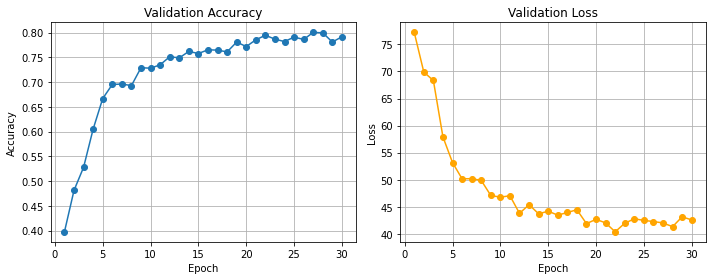

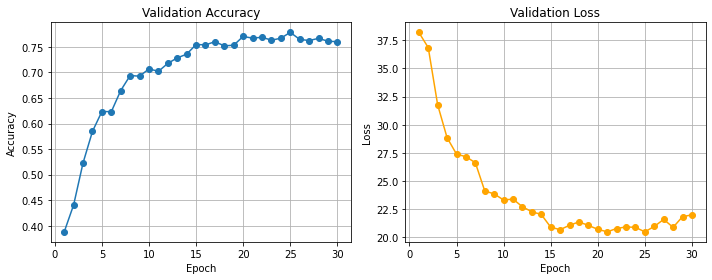

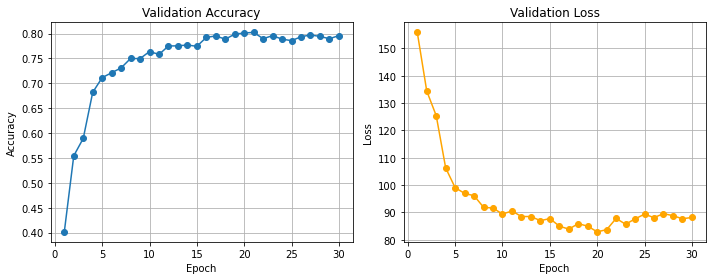

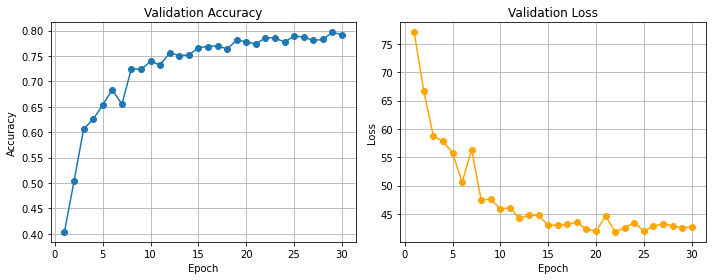

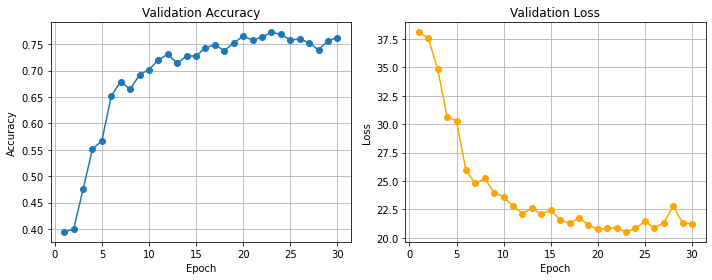

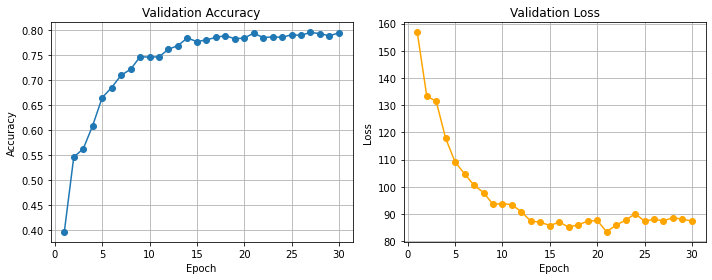

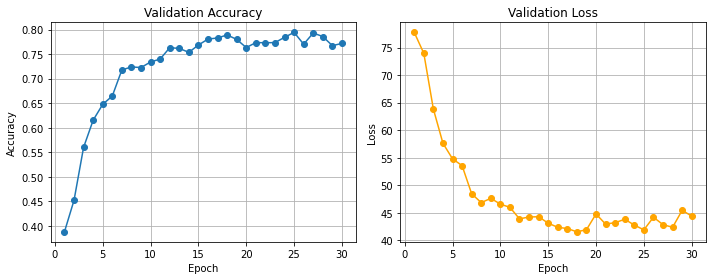

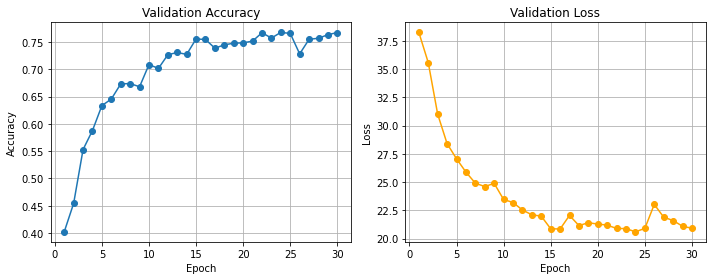

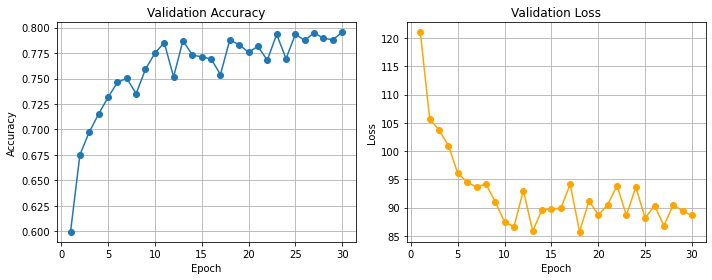

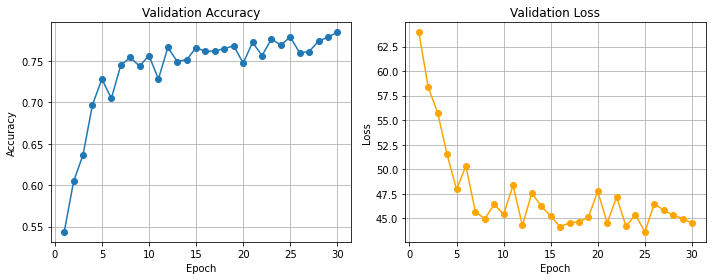

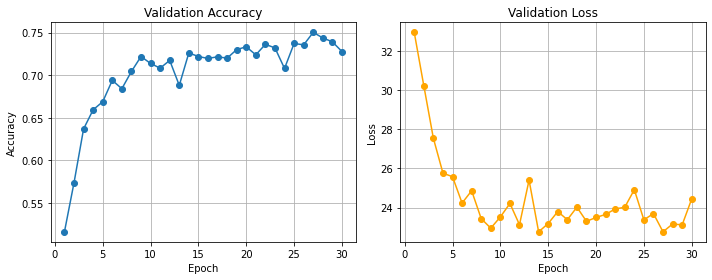

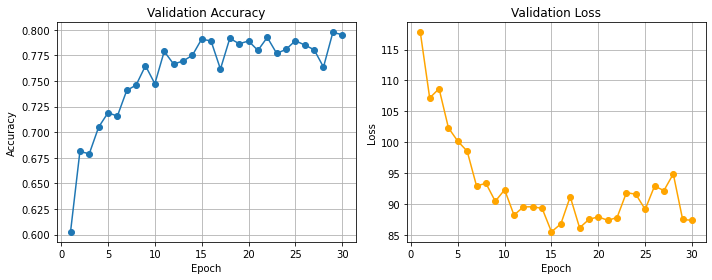

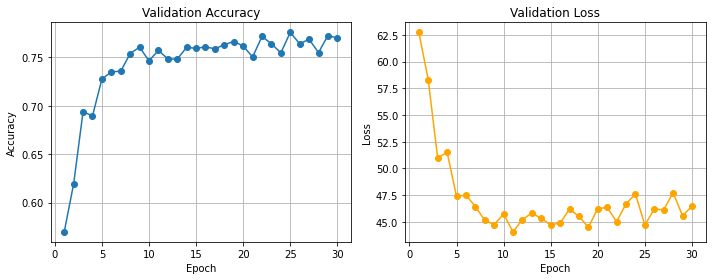

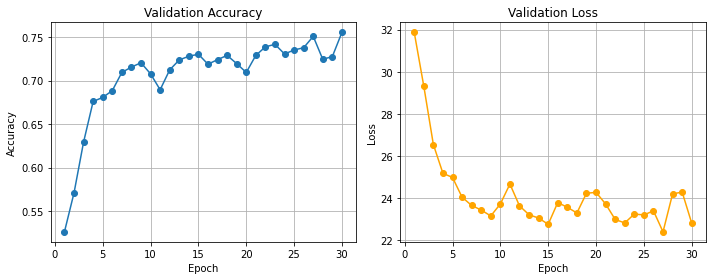

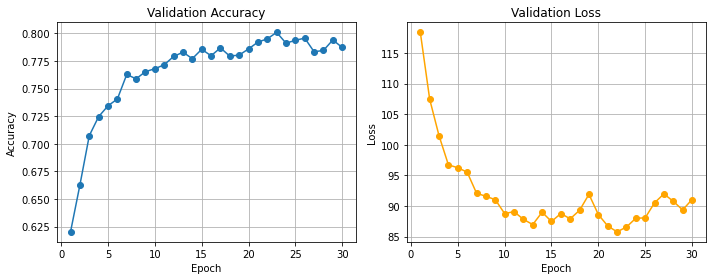

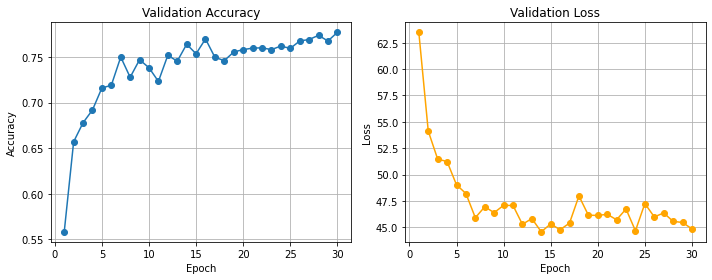

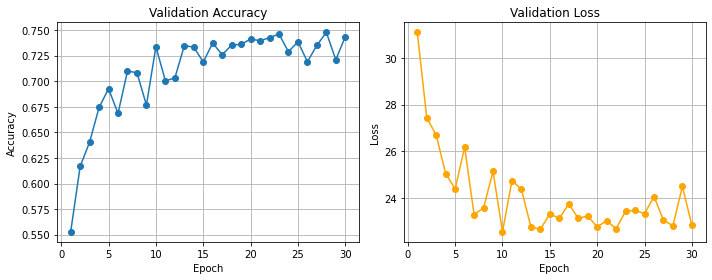

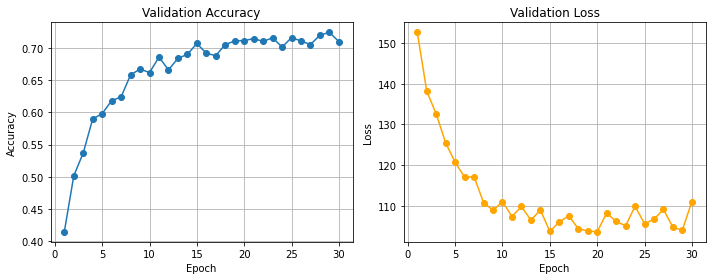

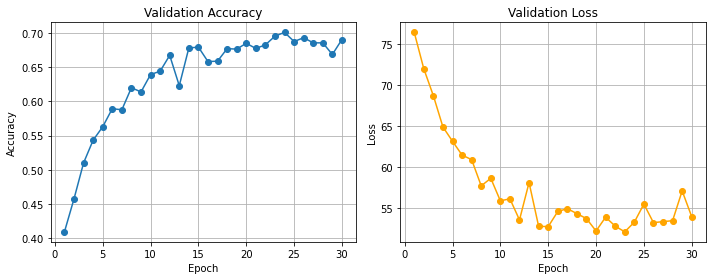

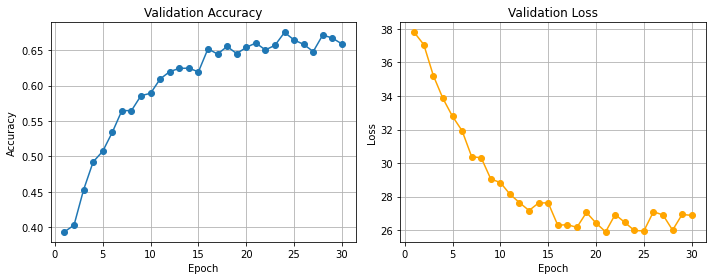

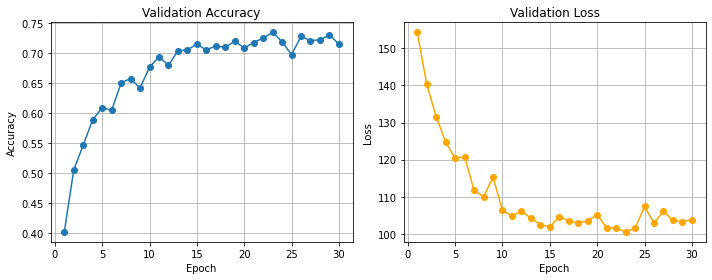

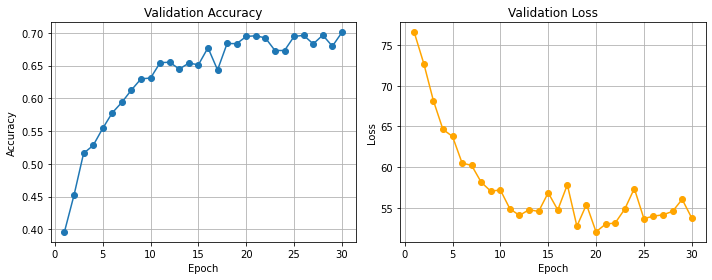

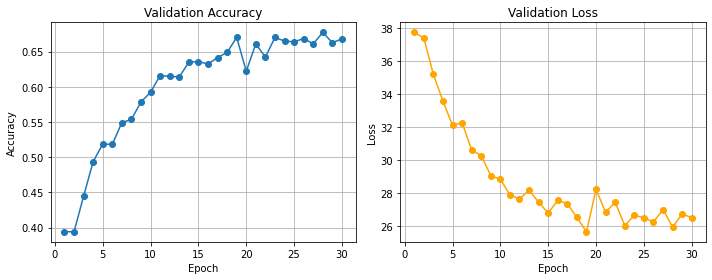

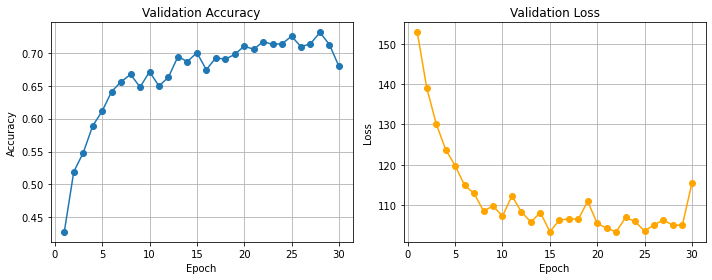

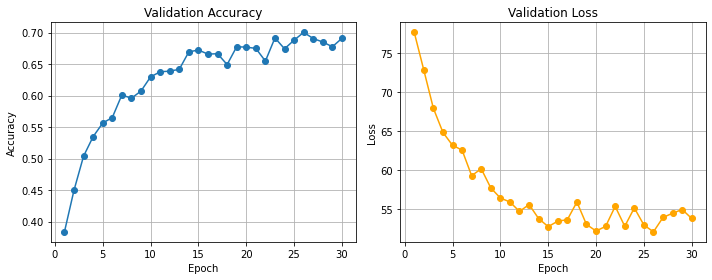

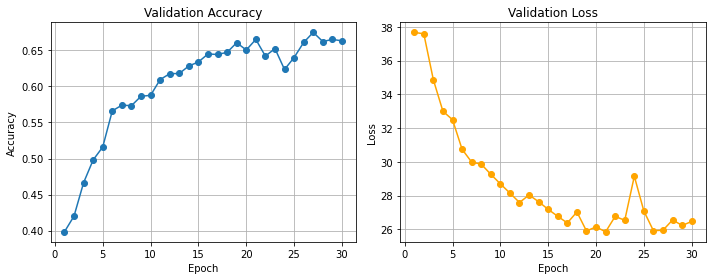

In [21]:
#训练
for res_values in Res_values:
    for lr in lr_values:
        for weight_decay in weight_decay_values:
            for batch_size in batch_size_values:
                epochs = 30
                total_train_step = 0
                
                model = ResNet(BasicBlock, res_values, num_classes=7)  
                model.cuda()
                best_acc = 0

                accuracies=[]
                losses = []

                train_data = torchvision.datasets.ImageFolder(root=Train_data_path, transform=train_transform)
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)

                test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
                test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False,drop_last=True)

                optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

                train_data_len = len(train_data)
                test_data_len = len(test_data)

                print(f"开始训练：lr={lr}, res={res_values},weight_decay={weight_decay},batch_size={batch_size}, epochs={epochs}")

                for i in range(epochs):
                    print("---------第{}轮训练开始---------".format(i+1))
                    model.train()
                    for data in train_loader:
                        img,target = data
                        img= img.cuda()
                        target = target.cuda()
                        output = model(img)

                        loss=loss_function(output,target)
                        optimizer.zero_grad()

                        loss.backward()
                        optimizer.step()
                        
                        total_train_step+=1

                        if total_train_step % 100==0:
                            print("训练次数{}，Loss：{}".format(total_train_step,loss.item()))
                    #测试步骤
                    total_test_loss = 0
                    total_accuracy = 0
                    with torch.no_grad():
                        model.eval()
                        for data in test_loader :
                            img,target = data
                            img = img.cuda()
                            target = target.cuda()
                            output= model(img)
                            loss = loss_function(output,target)
                            total_test_loss+=loss.item()
                            accuracy = (output.argmax(1) == target ).sum().item()
                            total_accuracy += accuracy
                    if(total_accuracy/test_data_len>best_acc):
                        best_acc = total_accuracy/test_data_len
                    print("正确率{}".format(total_accuracy/test_data_len))
                    accuracies.append(total_accuracy/test_data_len)
                    print("整体测试集上的Loss{}".format(total_test_loss))
                    losses.append(total_test_loss)
                
                best_acc_values_in_each.append(best_acc)
                results.append({
                    "Block_value":res_values,
                    'Learning Rate': lr,
                    'Weight Decay': weight_decay,
                    'Batch Size': batch_size,
                    'Epochs': epochs,
                    'Best Accuracy': best_acc
                })

                #画图并保存
                epochs = list(range(1, len(accuracies)+1))

                plt.figure(figsize=(10, 4))

                plt.subplot(1, 2, 1)
                plt.plot(epochs, accuracies, label='Accuracy', marker='o')
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")
                plt.title("Validation Accuracy")
                plt.grid(True)

                plt.subplot(1, 2, 2)
                plt.plot(epochs, losses, label='Test Loss', color='orange', marker='o')
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.title("Validation Loss")
                plt.grid(True)

                plt.tight_layout()

                save_path = os.path.join(folder_path, 
                                        f"accuracy_and_loss_Block_{res_values}_lr_{lr}_wd_{weight_decay}_bs_{batch_size}_epochs_{epochs[-1]}.png")
                plt.savefig(save_path)
                                
                print(f"图像已保存到: {save_path}")



In [22]:
#保存
df = pd.DataFrame(results)

# 保存路径
file_path = "../hyperparameter_results_res.xlsx"
df.to_excel(file_path, index=False)